## Homework 2 - AWS code

In [1]:
# import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import os
import requests
import tempfile
import json
import pathlib
import pickle
import tarfile
import joblib

# import sagemaker libraries
import boto3
import sagemaker
import sagemaker.session
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.parameters import ParameterInteger, ParameterString
from sagemaker.workflow.steps import ProcessingStep, TrainingStep
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ScriptProcessor
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.pipeline import Pipeline

# import ml libraries
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tabulate import tabulate

In [2]:
# define environmental variables
region = boto3.Session().region_name
sagemaker_session = sagemaker.session.Session()
role = sagemaker.get_execution_role()
default_bucket = sagemaker_session.default_bucket()
model_package_group_name = f"GamesModelPackageGroupName"

## Download dataset to S3

In [3]:
input_data_uri = 's3://sagemaker-us-east-2-323622603425/games/dirty_dataset.csv'
#input_data_uri = 's3://sagemaker-us-east-2-323622603425/games/clean_dataset_fixed.csv'



## Define pipeline parameters

In [5]:
processing_instance_count = ParameterInteger(
    name="ProcessingInstanceCount",
    default_value=1
)
processing_instance_type = ParameterString(
    name="ProcessingInstanceType",
    default_value="ml.m4.xlarge"
)
training_instance_type = ParameterString(
    name="TrainingInstanceType",
    default_value="ml.m4.xlarge"
)
model_approval_status = ParameterString(
    name="ModelApprovalStatus",
    default_value="PendingManualApproval"
)
input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)

## Create preprocessing file

In [6]:
%%writefile games/preprocessing.py

import argparse
import os
import requests
import tempfile
import numpy as np
import pandas as pd


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

feature_columns_names = [
    "type",
    "yearpublished",
    "minplayers",
    "maxplayers",
    "minage",
    "users_rated",
    "total_owners",
    "total_traders",
    "total_wanters",
    "total_wishers",
    "total_comments",
    "total_weights",
    "average_weight"
]
label_column = "average_rating"

columns_dtype = {
    "id": np.int64,
    "type": object,
    "name": object,
    "yearpublished": np.float64,
    "minplayers": np.int64,
    "maxplayers": np.int64,
    "minage": np.float64,
    "users_rated": np.float64,
    "average_rating": np.float64,
    "bayes_average_rating": np.float64,
    "total_owners": np.float64,
    "total_traders": np.float64,
    "total_wanters": np.float64,
    "total_wishers": np.float64,
    "total_comments": np.float64,
    "total_weights": np.float64,
    "average_weight": np.float64
}

if __name__ == "__main__":
    base_dir = "/opt/ml/processing"

    df = pd.read_csv(f"{base_dir}/input/dirty_dataset.csv", dtype=columns_dtype)
    #df = pd.read_csv(f"{base_dir}/input/clean_dataset_fixed.csv", dtype=columns_dtype)
    df.drop(columns=['id', 'name', 'bayes_average_rating'], inplace=True)
    numeric_features = list(feature_columns_names)
    numeric_features.remove("type")
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]
    )

    categorical_features = ["type"]
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]
    )

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )
    
    y = df.pop(label_column)
    X_pre = preprocess.fit_transform(df)
    y_pre = y.to_numpy().reshape(len(y), 1)
    
    X = np.concatenate((y_pre, X_pre), axis=1)
    
    np.random.shuffle(X)
    train, validation, test = np.split(X, [int(.7*len(X)), int(.85*len(X))])

    pd.DataFrame(train).to_csv(f"{base_dir}/train/train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(f"{base_dir}/validation/validation.csv", header=False, index=False)
    pd.DataFrame(test).to_csv(f"{base_dir}/test/test.csv", header=False, index=False)

Overwriting games/preprocessing.py


In [7]:
# create an instance of an SKLearnProcessor to pass in to the processing step
framework_version = "0.23-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name="sklearn-games-process",
    role=role,
)

In [8]:
# create a processing step
step_process = ProcessingStep(
    name="GamesProcess",
    processor=sklearn_processor,
    inputs=[
      ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),  
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test")
    ],
    code="games/preprocessing.py",
)

## Define step for model training

In [9]:
# specify model path where models saved
model_path = f"s3://{default_bucket}/GamesTrain"

In [10]:
# # configure algorithm and input dataset - KNN
# image_uri = sagemaker.image_uris.retrieve(
#     framework="knn",
#     region=region,
#     version="1",
#     py_version="py3",
#     instance_type=training_instance_type,
# )
# xgb_train = Estimator(
#     image_uri=image_uri,
#     instance_type=training_instance_type,
#     instance_count=1,
#     output_path=model_path,
#     role=role,
# )
# xgb_train.set_hyperparameters(
#     k=5, 
#     predictor_type='regressor',
#     sample_size=56918
# )

In [11]:
# configure algorithm and input dataset - XGboost
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type=training_instance_type,
)
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=training_instance_type,
    instance_count=1,
    output_path=model_path,
    role=role,
)
xgb_train.set_hyperparameters(
    objective="reg:linear",
    num_round=50,
    max_depth=5,
    eta=0.2,
    #eta=0.4,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    #subsample=0.85,
    silent=0
)

In [12]:
#%cd '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/image_uri_config/'

In [13]:
step_train = TrainingStep(
    name="GamesTrain",
    estimator=xgb_train,
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "train"
            ].S3Output.S3Uri,
            content_type="text/csv"
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv"
        )
    },
)

## Processing step for model evaluation

In [14]:
%%writefile games/evaluation.py

import json
import pathlib
import pickle
import tarfile
import joblib
import numpy as np
import pandas as pd
import xgboost
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if __name__ == "__main__":
    model_path = f"/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
    
    model = pickle.load(open("xgboost-model", "rb"))

    test_path = "/opt/ml/processing/test/test.csv"
    df = pd.read_csv(test_path, header=None)
    
    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)
    
    X_test = xgboost.DMatrix(df.values)
    
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    std = np.std(y_test - predictions)
    report_dict = {
        "regression_metrics": {
            "mse": {
                "value": mse,
                "standard_deviation": std
            },
            "r2":{
                "value": r2
            },
            "mae":{
                "value": mae
            },
        },
        "y_pred": predictions.tolist(),
        "y_test": y_test.tolist(),
    }

    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))

Overwriting games/evaluation.py


In [15]:
# create an instance of a ScriptProcessor that is used to create a ProcessingStep
script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="script-games-eval",
    role=role,
)

In [16]:
# create a processing step
evaluation_report = PropertyFile(
    name="EvaluationReport",
    output_name="evaluation",
    path="evaluation.json"
)
step_eval = ProcessingStep(
    name="GamesEval",
    processor=script_eval,
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model"
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs[
                "test"
            ].S3Output.S3Uri,
            destination="/opt/ml/processing/test"
        )
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="games/evaluation.py",
    property_files=[evaluation_report],
)

## Create pipeline

In [17]:
from sagemaker.workflow.pipeline import Pipeline

pipeline_name = f"GamesPipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type, 
        processing_instance_count,
        training_instance_type,
        model_approval_status,
        input_data,
    ],
    steps=[step_process, step_train, step_eval],
)

In [18]:
json.loads(pipeline.definition())

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m4.xlarge'},
  {'Name': 'ProcessingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m4.xlarge'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'InputData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-2-323622603425/games/dirty_dataset.csv'}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'GamesProcess',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': {'Get': 'Parameters.ProcessingInstanceType'},
      'InstanceCount': {'Get': 'Parameters.ProcessingInstanceCount'},
      'VolumeSizeInGB': 30}},
    'AppSpecification': {'

## Start pipeline

In [19]:
pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-2:323622603425:pipeline/gamespipeline',
 'ResponseMetadata': {'RequestId': '63c488dc-a206-4957-9c9d-97b768437934',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '63c488dc-a206-4957-9c9d-97b768437934',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '81',
   'date': 'Mon, 01 Nov 2021 23:29:30 GMT'},
  'RetryAttempts': 0}}

In [20]:
execution = pipeline.start()

## Examin execution

In [21]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-2:323622603425:pipeline/gamespipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-2:323622603425:pipeline/gamespipeline/execution/u87qzifcpr98',
 'PipelineExecutionDisplayName': 'execution-1635809370680',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2021, 11, 1, 23, 29, 30, 613000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2021, 11, 1, 23, 29, 30, 613000, tzinfo=tzlocal()),
 'CreatedBy': {},
 'LastModifiedBy': {},
 'ResponseMetadata': {'RequestId': '74542f57-b78b-45b0-9748-91ec06ef30ca',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '74542f57-b78b-45b0-9748-91ec06ef30ca',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '391',
   'date': 'Mon, 01 Nov 2021 23:29:30 GMT'},
  'RetryAttempts': 0}}

In [22]:
execution.wait()

In [23]:
execution.list_steps()

[{'StepName': 'GamesEval',
  'StartTime': datetime.datetime(2021, 11, 1, 23, 38, 29, 495000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2021, 11, 1, 23, 43, 38, 78000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-2:323622603425:processing-job/pipelines-u87qzifcpr98-gameseval-fbwpvy2hrd'}}},
 {'StepName': 'GamesTrain',
  'StartTime': datetime.datetime(2021, 11, 1, 23, 34, 35, 505000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2021, 11, 1, 23, 38, 28, 843000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-2:323622603425:training-job/pipelines-u87qzifcpr98-gamestrain-q20xrdsgpg'}}},
 {'StepName': 'GamesProcess',
  'StartTime': datetime.datetime(2021, 11, 1, 23, 29, 31, 715000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2021, 11, 1, 23, 34, 34, 691000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'ProcessingJob': {'Ar

In [24]:
# evaluation_json = sagemaker.s3.S3Downloader.read_file("{}/evaluation.json".format(
#     step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
# ))
# json.loads(evaluation_json)

In [25]:
evaluation_json = sagemaker.s3.S3Downloader.read_file("{}/evaluation.json".format(
    step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
))
y_pred = json.loads(evaluation_json)['y_pred']
y_test = json.loads(evaluation_json)['y_test']
mse = json.loads(evaluation_json)['regression_metrics']['mse']['value']
mae = json.loads(evaluation_json)['regression_metrics']['mae']['value']
r2 = json.loads(evaluation_json)['regression_metrics']['r2']['value']

## Plots and metrics

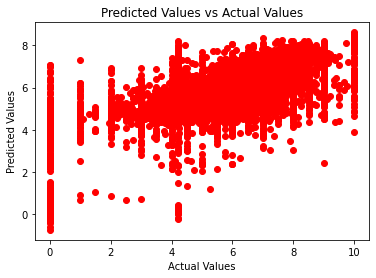

In [26]:
plt.scatter(x=y_test, y=y_pred, color='red')
plt.title('Predicted Values vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()



# plt.scatter(y_test, y_pred, color='red')
# plt.title('Predicted Values vs Actual Values')
# plt.show()

In [27]:
# assign data
mydata = [('Mean Squared Error', mse), 
          ('Mean Absolute Error', mae), 
          ('R-Squared', r2)]
  
# create header
head = ["Metric", "Value"]
  
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Mean Squared Error  | 1.65412  |
+---------------------+----------+
| Mean Absolute Error | 0.826911 |
+---------------------+----------+
| R-Squared           | 0.813949 |
+---------------------+----------+
